# Social Computing/Social Gaming - Summer 2021
# Exercise Sheet 5 - Hate Speech
Online hate speech is a large scale phenomenon that gained more and more traction in modern society in recent years. Violence attributed to online hate speech has increased worldwide. The same technology that allows social media to galvanize activist movements and NGOs can be used by hate/crime groups seeking to organize and recruit. It also allows conspiration theorists to reach audiences far broader than their core community. It is time – now more than ever –  to put systems in place that make sure social media is not used as a tool to conduct criminal activities. Fortunately, modern technology allows us to do just that.

In this exercise sheet, we will attempt to accurately and automatically detect two instances of hate speech in Twitter: sexism and racism. The first step in this process will be to prepare the data before it is fed to the model. We do this with the help of the Universal Sentence Encoder, which is explained in more detail later. Additionally, we also need to encode the labels and split the data.

We then take two different approaches in classifying the data. In other words, we will create, train, evaluate and compare two models. One of them is purely based on text (the Base Model) and the other also takes the social context of the users into account (the Social Model).

## Why Twitter?
Hate crimes are communicative acts, often provoked by events that incite retribution in a targeted group. The continued growth of online social networks and micro-blogging Web services, such as Twitter, enable an extensive and near real-time data source through which the analysis of hateful and antagonistic responses to “trigger” events can be undertaken. Such data affords researchers with the possibility to measure the online social mood and emotion following large-scale, disruptive, and emotive events. Twitter is a defensible and logical source of data for such analysis given that users of social media are more likely to express emotional content due to deindividuation (anonymity, lack of self-awareness in groups, disinhibition) [1].

## Task 5.0: The Data
For this, we have picked the dataset of Waseem and Hovy [2], in a slightly modified version. The collection originally contained 16,914 labeled tweets, however some of them are not accessible via Twitter API anymore. As a consequence, the dataset now contains 16,849 tweets divided in the following categories: 3,378 *sexism*, 1,970 *racism* and 11,501 *neither*.

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# Reads the data set from a .csv file
waseem_hovy = pd.read_csv('tweets.csv')
waseem_hovy = waseem_hovy.astype(str)

# This drop operation is necessary because of an inconsistency in the dataset
waseem_hovy = waseem_hovy.drop([3343, 3344])
waseem_hovy = waseem_hovy[['text', 'label']]

# We need to do a unique and precise reordering to match with graph information later on
unique_tweets, indices = np.unique(waseem_hovy['text'].to_numpy(), return_index=True)
ordered_labels = waseem_hovy['label'].to_numpy()[indices]
waseem_hovy = pd.DataFrame(np.stack((unique_tweets, ordered_labels), axis=1), columns=['text', 'label'])

In [ ]:
# See the summary of the dataset's content

print("TOTAL TWEETS: {}, RACIST: {}, SEXIST: {}, NEITHER: {}".\
      format(len(waseem_hovy), len(waseem_hovy[waseem_hovy["label"] == 'racism']), len(waseem_hovy[waseem_hovy["label"] == 'sexism']), len(waseem_hovy[waseem_hovy['label'] == 'none'])))

## Task 5.1: Preprocessing 

### a) Encode the labels
In order for [Keras](https://keras.io/about/) [3] to work with the labels, they need to have a specific format. For every tweet, we need a 3-dimensional vector where the assigned category is marked by `1` for that index and the rest of the vector is marked with `0`. This kind of representation is called One Hot Encoding.  

Map the labels from the `label_mapping = ['sexism' 'none' 'racism']` to a 3-dimensional vector.

**Example**: If a tweet is racist, the vector will look like this: `[0, 0, 1]`.

In [ ]:
from sklearn.preprocessing import LabelBinarizer

In [ ]:
# Extract labels from dataset

labels = np.array(waseem_hovy["label"].tolist())

# TODO: Encode labels as binary One Hot vectors
# Hint: First map the labels to integer than binarize them


# Shows the actual shape of the labels
print(labels.shape)
print(label_mapping)

### b) Universal Sentence Encoder
Google's Universal Sentence Encoder ([USE](https://tfhub.dev/google/universal-sentence-encoder/4) [4]) is a convenient way to map any type of sentence to a 512-dimensional vector. In these 512-dimensional vectors semantic meaning is encoded.

In [ ]:
import tensorflow_hub as hub

# Run this code block only once as the download will take some time and embedding is very memory expensive!
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In this task you are suppossed to get a feeling for this type of embedding. Find a pair of sentences that are similar in their meaning but not syntactically. After that, think of two semantically very different sentences. 
Obtain the values for them and compare them.

**TODO: Write your observations here**

In [ ]:
# Try out USE here



In [ ]:
# TODO: Now encode our dataset's tweets



## Task 5.2: Base Model

### a) Base Model creation
In this code we create our base model and train it afterwards using the Keras library. We use a simple Neural Network to build this model. You can read about Neural Networks here in case you are not familiar with them.
You can get a basic intuition for Neural Networks [here](https://medium.com/@shaistha24/basic-concepts-you-should-know-before-starting-with-the-neural-networks-nn-3-6db79028e56d) [5]. 

For the base model we have our 512 dimensional input layer. Then we have a fully connected layer with 100 nodes and with a dropout rate of 0.5 is added. For now, you do not need to know what dropout is. After the dropout, another fully connected layer with 50 nodes is added and we once again add a 0.5 dropout rate.
Our output layer has 3 nodes: One for "sexism", "none" and "racism". The computed values for these last 3 nodes correspond to the probability of belonging to either one of our categories.

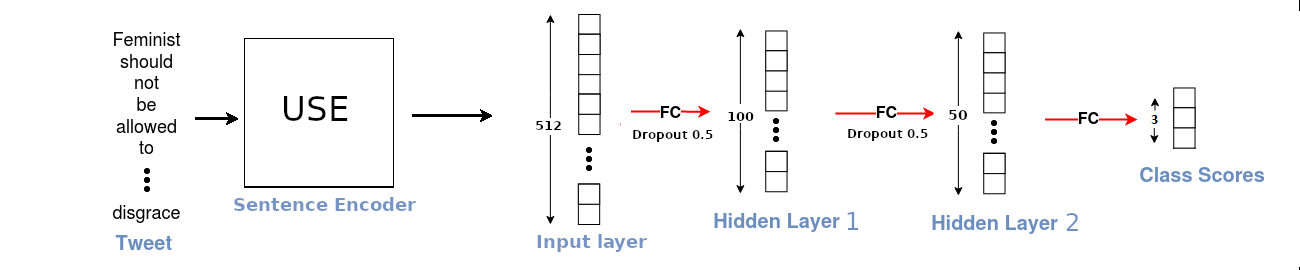

![title](img/base_model.png)

In [ ]:
from keras import layers
from keras.models import Model
from keras import backend as K
import tensorflow as tf

In [ ]:
BATCH_SIZE = 32

In [ ]:
ENCODING_DIM = 512

text = layers.Input(shape=(ENCODING_DIM, ))

x1 = layers.Dense(100, activation='relu')(text)
x1 = layers.Dropout(0.5)(x1)

# TODO: The 50 nodes layer with 0.5 dropout is missing. Add this layer between the 100 layer and the output layer


output = layers.Dense(3, activation="softmax") (x2)

base_model = Model(inputs=[text], outputs=output)

In [ ]:
# Compiles the model defining loss, accuracy metric and optimizer

# Check the internet to unterstand what impact the learning rate (lr) has!
optimizer = tf.keras.optimizers.Adam(lr=0.00005)

base_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['categorical_accuracy'])
base_model.summary()

### b) Train-Test split for Base Model
Splitting our labeled data into a train test and validation set is a common practice. 
* Train set: This set is used to train our model on. The model will try to learn from it.
* Validation set: This set is used to choose hyper-parameters. Since creating good models requires to find the right parameters (e.g. what kind of activation function, how many epochs etc.) this set is used to maximize the performance of a model for a fixed choice of parameters.
* Test set: This set is used to evaluate our final model on. After the model has been trained and a final decision for hyper parameters has been made, the model will be evaluated on this set only. No more parameters should be changed after that.

This approach helps to identify models that actually generalize well and not just perform well because we adapted the parameters to maximize the performance on one particular set.

We will use 60% of our dataset to train our model (the train set) and the remaining 20% to evaluate our model (the test set).

**Hint:** The sklearn library offers a function that could help you out with this task.

In [ ]:
from sklearn.model_selection import train_test_split

# TODO: Split tweets and labels in Train/Test/Validation 60/20/20


print("Training data shape: {}, Labels shape: {}".format(X_train.shape, y_train.shape))
print("Test data shape: {}, Labels shape: {}".format(X_test.shape, y_test.shape))
print("Validation data shape: {}, Labels shape: {}".format(X_val.shape, y_val.shape))

### c) Train the Base Model

**1.** Train the model. You can do so by using the `fit()` function from the Keras library. Call the function with `epochs=20`. Assign the return value from the `fit()` function to the `model_training` variable. It is then used to plot the model's accuracy on the train and validation set at each epoch.

In [ ]:
from matplotlib import pyplot as plt

BATCH_SIZE = 32

# TODO: Train the model
# Hint: When using the fit function, also pass the validation_data as a parameter

model_training = # TODO

# Print the model's history and plot the loss for each epoch
print(model_training.history)
plt.plot(model_training.history['loss'])
plt.plot(model_training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**2.** After you have looked at the graph, what do you think is an appropriate amount of `epochs`? Briefly explain at which amount of epochs the model seems to be underfitting or overfitting and how this depends on the learning rate?

**TODO: Write your observations here**

### d) Evaluate the Base Model

The F1 score is a universal measurement of a test's accuracy. It is calculated as the harmonic mean of *precision* and *recall*. 

- **precision** refers to the number of true positives divided by the number of all positives
- **recall** refers to the number of true positives divided by the number of relevant elements  


$$F_{1} = \frac{2}{recall^{-1} + precision^{-1}} = \frac{tp}{tp+\frac{1}{2}(fp+fn)}$$  

where
*   tp = true positives
*   fp = false positives
*   fn = false negatives  

**1.** Why would we prefer the F1 Score over only the precision?

**2.** Evaluate the text model with an F1 score.

**TODO 1: Write your explanation here**

In [ ]:
from src.evaluation import f1_score_overall

In [ ]:
# TODO 2: Evaluate text model
# Hint: You can lookup the evaluation.py in the src folder for documentation



## Task 5.3: Preprocessing for Social Model
Now that we have evaluated our base model we can try to enhance it by using some sort of a social context. To do so, we are using our base model's prediction to compute an average hate score for each of the followers of an author. This means that for each author we take all his follower's tweets and predict the label. We then take the average of each prediction which results in our average hate score.

For each tweet we then not only feed in the tweet itself, but also the hate score.

### Load adjacency matrix for users

In order to create our social model, we first need to load the adjacency matrix. This matrix represents the follower network between all users that have written the 16849 tweets (crawled by Linda Jahn [6]). You can check the `extend_data.ipynb` file to find out how the adjacency matrix was created.

The 16849 tweets were written by 2031 distinct users. This results in a 2031x2031 matrix.

In [ ]:
# Load users adjacency matrix
users_adjacency_matrix = np.load("pickle_files/users_data/users_adjacency_matrix.npy")

### a) Graph visualization & manipulation
Now we are going to plot the previously loaded adjacency matrix. Since we are going to feed the matrix to the Neural Network later, and because the user network is just a tiny subset of the whole Twitter network it is important to check if the network contains any useful information.


**1.** Plot the graph corresponding to the given adjacency matrix.  
**Note:** For better visualization, the nodes are color-coded based on their degree.

In [ ]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt

In [ ]:
def show_graph(users_adjacency_matrix):
    
    # TODO 1:
    
    
    print("Total number of nodes:", nx.number_of_nodes(graph))
    
    from matplotlib.pyplot import figure
    figure(num=None, figsize=(64, 50), dpi=100)
    nx.draw(graph,
            node_size=300,
            node_color=range(nx.number_of_nodes(graph)),
            cmap=plt.cm.Reds,
            pos=nx.spring_layout(graph)
           )
    plt.show()

    
show_graph(users_adjacency_matrix)

**2.** Briefly describe the graph. How many communities do you think it depicts? 

**TODO 2: Write your observations here**

**3.** Now let us try to actually calculate the number of communities within this graph. First, get rid of the uninteresting nodes that have zero or very few edges and just inspect the "core" graph. Expand on the code that you have written in the exercise above.  
**Hint**: You can do this by excluding all nodes with an `nx.eigenvector_centrality()` lower than $10^{-8}$.

In [ ]:
def show_graph_core(users_adjacency_matrix):
    
    # TODO 3:
    
    
    print("Total number of significant nodes:", nx.number_of_nodes(graph))
    
    from matplotlib.pyplot import figure
    figure(num=None, figsize=(64, 50), dpi=100)
    nx.draw(graph,
            node_size=1000,
            node_color=range(nx.number_of_nodes(graph)),
            cmap=plt.cm.Reds,
            pos=nx.spring_layout(graph)
           )
    plt.show()

    
show_graph_core(users_adjacency_matrix)

**4.** Do you think the social context could further improve our hate speech detection model? Find at least 2 pros and 2 cons.

**TODO 4: Write your observations here**  

### b) Employment of our Base Model to predict the hatefulness of an author's followers

Now that we have a trained model, we can use it to predict the hatefulness for any tweet. Therefore, we can use it to predict an average hate score for each follower of an author. This means that we predict the label for each tweet of an author's follower and then compute an average across all of these predictions. 

**1.** Predict all encoded tweets with the Base Model

In [ ]:
# TODO 1:



In the following code cell we load the authorship numpy array. It contains the author ID of each tweet.

In [ ]:
# Loads authorship index
authors_idx = np.load("pickle_files/users_data/authorship.npy")
authors_idx = np.reshape(authors_idx, newshape=(-1, 1))

**2.** Now for every tweet of our dataset we need to compute its authors hate score. Therefore:
 * First define a function `get_all_followers` that return all followers for a given user.
 * Then create a list `his_followers` that contains all followers for each user.
 * Now assign the hate predictions for each of all the followers tweets.
 * Finally in `user_avg_score` compute the hate score for each user by averaging out all his followers' tweets' hate scores. If there are no followers' tweets, assign our pre-computed average values `default_hate_score`.

In [ ]:
default_hate_score = np.array([0.19446494, 0.75084399, 0.0546911])

# TODO 2:



In [ ]:
# Put authors' hate scores in the order of the tweets
tweets_author_hate_score = list((map(lambda x: user_avg_score[int(x)], authors_idx))) 

tweets_author_hate_score = np.array(tweets_author_hate_score)

## Task 5.4: Social Model

Now that we have our social context prepared, we can build and train our Social Model using that information.

### a) Social Model creation

With our social context we have 2 separate networks: 
* Our text network that processes the tweet (the same as the base model from before)
* Our hate score network that basically decides how important the average hate score for the classification is

Our 2 separate networks are concatenated and one last hidden layer with 100 nodes is added. 

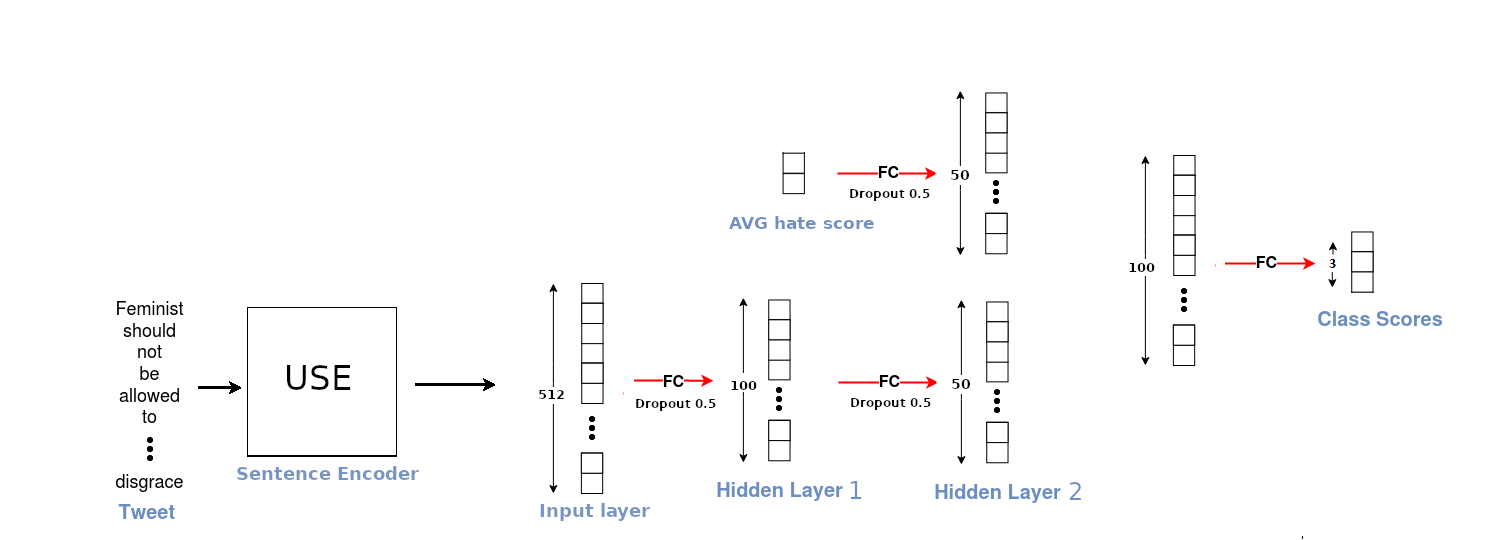

Now define our new neural network `social_model` according to the graphic above. You can lookup most of the syntax in exercise ***5.2 a)***.

In [ ]:
# TODO:



In [ ]:
# Compiles the model defining loss, accuracy metric and optimizer

optimizer = tf.keras.optimizers.Adam(lr=0.00005)

social_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['categorical_accuracy'])
social_model.summary()

### b) Train-Test split for Social Model
Now split the data in Train/Val/Test 60/20/20 as seen in the Base Model. This time you have to create an additional set for the Hate Score.

In [ ]:
# TODO:


print("Training data shape: {}, Labels shape: {}, Hate Score shape: {}".format(X_train.shape, y_train.shape, a_train.shape))
print("Test data shape: {}, Labels shape: {}, Hate Score shape: {}".format(X_test.shape, y_test.shape, a_test.shape))
print("Validation data shape: {}, Labels shape: {}, Hate Score shape: {}".format(X_val.shape, y_val.shape, a_val.shape))

### c) Train and Evaluate the Enhanced Model
Once again, train and evaluate the model with a F1 Score. Use 20 `epochs` and `batch_size` of 32.

In [ ]:
from matplotlib import pyplot as plt

# TODO: Train the model

model_training = # TODO

# Print the model's history and plot the loss for each epoch
print(model_training.history)
plt.plot(model_training.history['loss'])
plt.plot(model_training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from src.evaluation import f1_score_overall

# TODO: Evaluate the model with a F1 Score



## Task 5.5: Discussion and comparison

* Compare the performances of our two models in your own words

* Why do you think it improved? 

* Can you think of any other social context to further improve our model?

**TODO: Write your thoughts here**

## References

[1] Festinger, L., Pepitone, A. and Newcomb, T. (1952) *Some Consequences of De-Individuation in a Group.* Journal of Abnormal and Social Psychology, 47, 382-389.
<br>[2] Waseem, Z., & Hovy, D. (2016). *Hateful symbols or hateful people? Predictive features for hate speech detection on Twitter.* In Proceedings of the naacl student research workshop (pp. 88-93).
<br>[3] https://keras.io/about/
<br>[4] https://tfhub.dev/google/universal-sentence-encoder/4
<br>[5] https://medium.com/@shaistha24/basic-concepts-you-should-know-before-starting-with-the-neural-networks-nn-3-6db79028e56d
<br>[6] Jahn, L. (2020). *Leveraging Social Network Data for Hate Speech Detection.* Master
Thesis, Technical University of Munich, Department of Informatics.